# Projeto C318 (ML)

- **Detecção de ambientes poluidos para tratamento de focados em áreas especificas**
- **Objetivo**: Estudar o dataset encontrado com dados de medidores de fatores do meio ambiente de um local, entender quais fatores realmente afetam o que chamamos de "qualidade do ambiente" trazendo a classificação deste lugar como poluido. Além disso criar um modelo capaz de identificar por meio de dados de medidores destes fatores se o ambiente é poluido ou não, permitindo assim o tratamento localizado de ONGs e Orgãos publicos.

## Imports e configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import joblib

In [2]:
path = "../data/pollution_data_brazil.csv"
sep = ","
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (12, 6)

## Carregamento dos dados e analise inicial

In [3]:
data = pd.read_csv(path, sep=sep)
df_train, df_test = train_test_split(data, test_size=0.3, random_state=42)

print(df_train.shape)
print(df_test.shape)

df_train.head()

(1176, 22)
(504, 22)


,Unnamed: 0,city,timestamp,temperature,wind,humidity,dew_point,pressure,uv_index,O3_aqi,...,CO_medida,NO2_aqi,NO2_medida,PM10_aqi,PM10_medida,PM2_5_aqi,PM2_5_medida,SO2_aqi,SO2_medida,polluted
1635,1635,manaus,2025-06-01 12:00,28.0,10.0,78.0,24.0,1016.0,7.0,22.0,...,160.0,1.0,1.53,10.0,10.86,47.0,10.64,1.0,1.68,1
526,526,belo_horizonte,2025-05-27 21:00,19.0,0.0,76.0,15.0,1023.0,0.0,24.0,...,150.0,6.0,10.97,3.0,4.39,15.0,3.95,1.0,2.62,0
1376,1376,belo_horizonte,2025-05-31 10:00,22.0,13.0,69.0,16.0,1023.0,4.0,17.0,...,190.0,3.0,6.17,5.0,4.06,21.0,4.02,3.0,5.16,0
221,221,ribeirao_preto,2025-05-26 15:00,29.0,11.0,27.0,8.0,1018.0,3.0,41.0,...,140.0,1.0,1.80,9.0,9.10,52.0,10.75,1.0,1.35,1
113,113,porto_alegre,2025-05-26 04:01,18.0,5.0,94.0,18.0,1016.0,0.0,31.0,...,180.0,5.0,11.28,24.0,27.75,81.0,27.69,3.0,8.00,1


Analisando a estrutura dos dados, temos a cidade onde os sensores estão situados, a data da medida e diversas metricas da condição do meio ambiente. Podemos ver que todas as metricas sobre concentração de algum elemento tem uma coluna aqi e outra medida. Buscando entender um pouco melhor, e para esclarecer a diferença:

- **Medida**: Valor medido bruto, ou seja, o dado obtido direto do sensor.
- **AQI**: Dado padronizado dentro de intervalos, que mostram o nivel de poluição que isso pode trazer, como dois elementos possuem medidas diferentes, são colocados nessa forma para trazer uma melhor comparação e relação entre eles.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1635 to 1126
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1176 non-null   int64  
 1   city          1176 non-null   object 
 2   timestamp     1176 non-null   object 
 3   temperature   1176 non-null   float64
 4   wind          1176 non-null   float64
 5   humidity      1176 non-null   float64
 6   dew_point     1176 non-null   float64
 7   pressure      1176 non-null   float64
 8   uv_index      1166 non-null   float64
 9   O3_aqi        1176 non-null   float64
 10  O3_medida     1176 non-null   float64
 11  CO_aqi        1176 non-null   float64
 12  CO_medida     1176 non-null   float64
 13  NO2_aqi       1176 non-null   float64
 14  NO2_medida    1176 non-null   float64
 15  PM10_aqi      1176 non-null   float64
 16  PM10_medida   1176 non-null   float64
 17  PM2_5_aqi     1176 non-null   float64
 18  PM2_5_medida  1176 non-null   

Podemos perceber que todas as colunas tem os tipos como valores já tratados, assim não precisamos realizar nenhum tratamento incial do tipo dos dados. Além disso, as colunas não possuem valores nulos, o que facilita muito evitando um processo de limpeza e tratamento. 

## EDA

In [5]:
df_train.describe()

,Unnamed: 0,temperature,wind,humidity,dew_point,pressure,uv_index,O3_aqi,O3_medida,CO_aqi,CO_medida,NO2_aqi,NO2_medida,PM10_aqi,PM10_medida,PM2_5_aqi,PM2_5_medida,SO2_aqi,SO2_medida,polluted
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1166.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,832.038265,20.212585,10.693027,73.571429,14.870748,1018.377551,1.198113,24.765306,51.801276,1.719388,217.738095,6.034864,12.106769,11.958333,13.722866,40.919218,12.034082,1.804422,3.659269,0.572279
std,485.469709,6.169027,7.279010,15.479953,5.667102,3.958978,2.099507,9.997413,23.232444,1.856879,190.201647,8.117309,15.759161,12.547407,15.484748,31.592961,13.016332,2.043155,3.993884,0.494959
min,0.000000,3.000000,0.000000,27.000000,2.000000,1004.000000,0.000000,1.000000,1.920000,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.450000,1.000000,1.000000,0.000000
25%,411.500000,16.000000,5.000000,64.000000,11.000000,1015.000000,0.000000,19.000000,36.700000,1.000000,120.000000,1.000000,2.605000,5.000000,4.750000,17.000000,4.245000,1.000000,1.000000,0.000000
50%,830.500000,21.000000,10.000000,77.000000,14.000000,1019.000000,0.000000,24.000000,49.480000,1.000000,160.000000,3.000000,6.450000,7.000000,8.525000,31.500000,7.675000,1.000000,2.255000,1.000000
75%,1241.500000,26.000000,14.000000,85.000000,19.000000,1022.000000,2.000000,30.000000,63.395000,2.000000,230.000000,7.000000,14.107500,15.000000,16.062500,56.000000,14.932500,1.000000,4.450000,1.000000
max,1679.000000,32.000000,40.000000,100.000000,26.000000,1026.000000,10.000000,84.000000,159.260000,14.000000,1430.000000,51.000000,99.250000,73.000000,117.430000,168.000000,91.040000,16.000000,29.640000,1.000000


### Grafico para realizar a comparação entre as colunas com medida e aqi

In [6]:
def plot_aqi_vs_medida(df):
    medida_cols = [c for c in df.columns if c.endswith("_medida")]

    for medida_col in medida_cols:
        pol = medida_col.replace("_medida", "")
        aqi_col = pol + "_aqi"

        if aqi_col not in df.columns:
            continue

        plt.figure(figsize=(7,5))
        plt.scatter(df[medida_col], df[aqi_col])
        plt.xlabel(f"{medida_col} (concentração real)")
        plt.ylabel(f"{aqi_col} (AQI padronizado)")
        plt.title(f"{pol.upper()}: Medida vs AQI")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


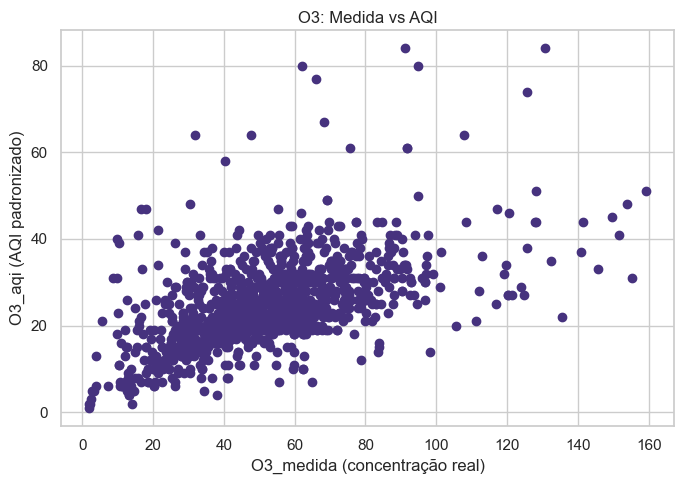

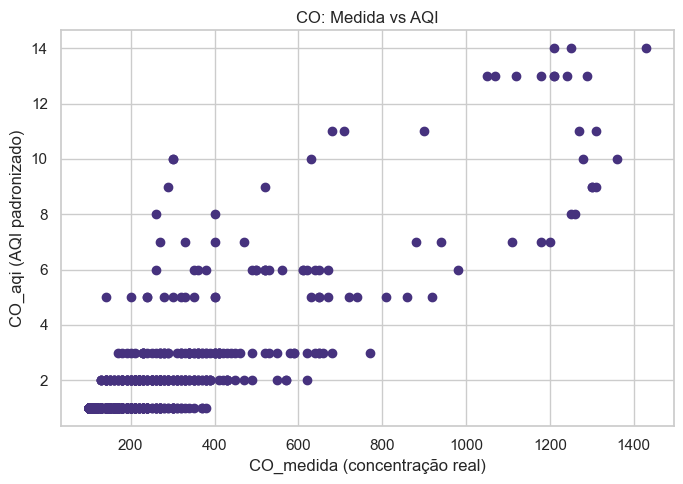

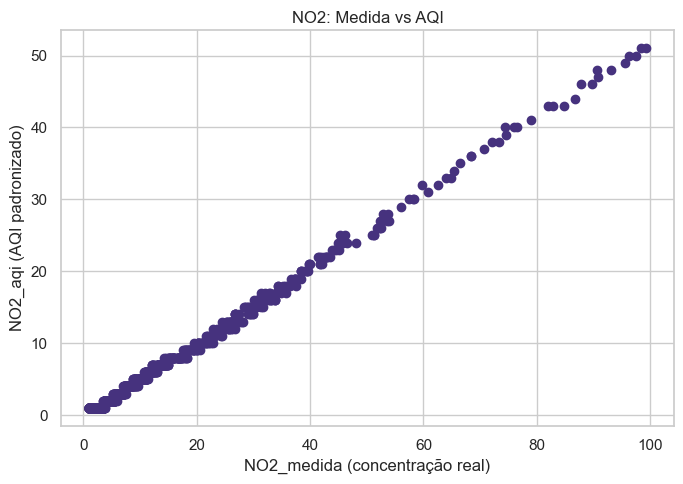

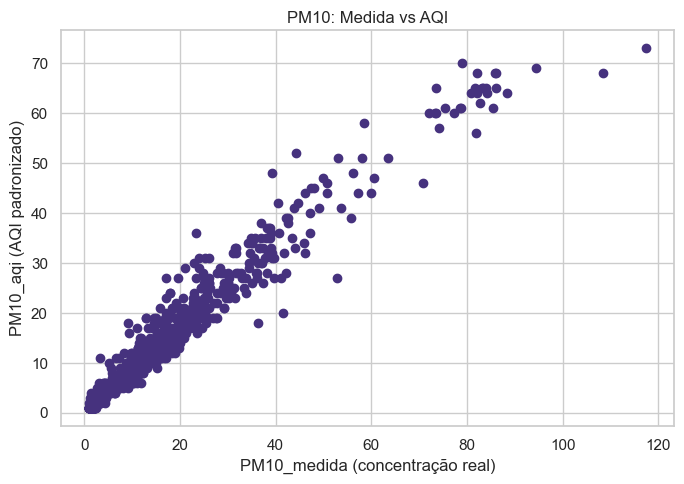

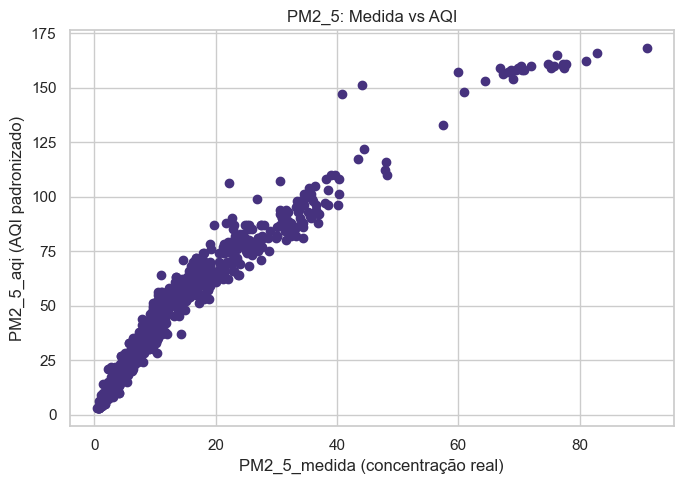

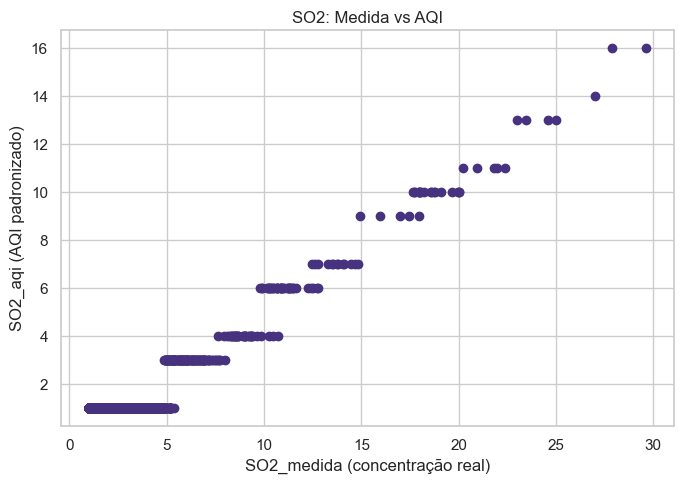

In [7]:
plot_aqi_vs_medida(df_train)

Aqui podemos confirmar que as colunas com AQI possuem um valor mais normalizado e padronizado. Trazendo uma reflexão: Qual dados faz mais sentido para uma analise e classificação de qualidade do ambiente?

In [8]:
cols_poluentes = [
    "O3_medida", "O3_aqi", "CO_medida", "CO_aqi", "NO2_medida", "NO2_aqi", "PM10_medida", "PM10_aqi",
    "PM2_5_medida", "PM2_5_aqi", "SO2_medida", "SO2_aqi"
]

### Graficos para variaveis numéricas

In [9]:
def eda_histograms(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns

    df[cols].hist(bins=30, figsize=(15, 12))
    plt.suptitle("Distribuição das variáveis numéricas")
    plt.show()


def eda_boxplots(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns

    for col in cols:
        plt.figure(figsize=(8, 3))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot - {col}")
        plt.show()

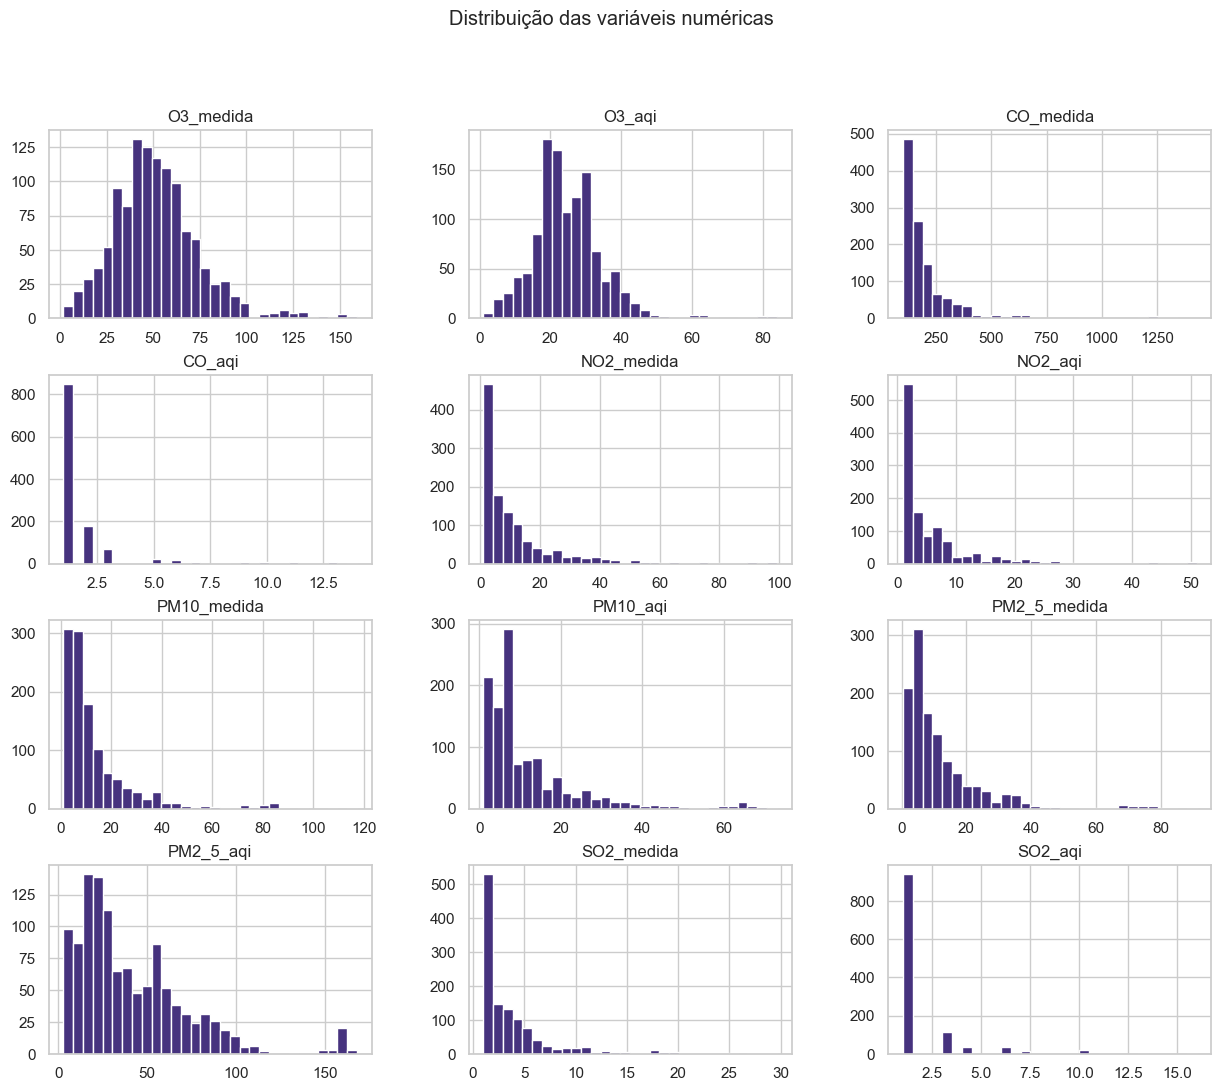

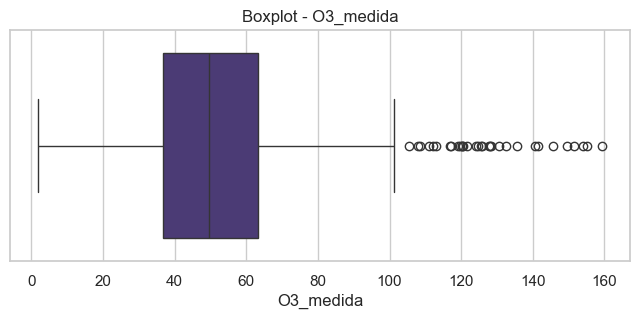

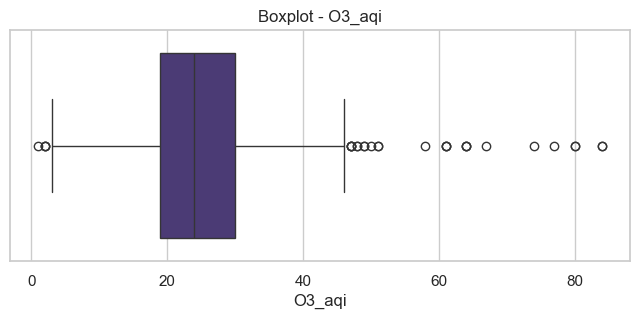

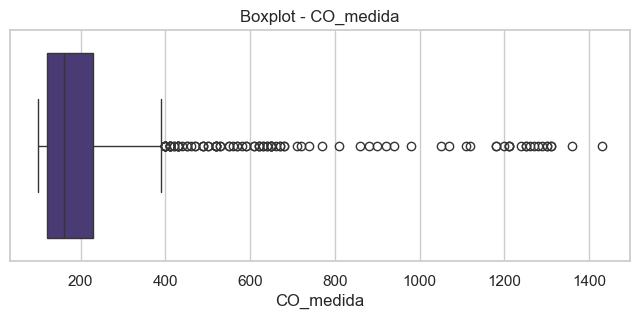

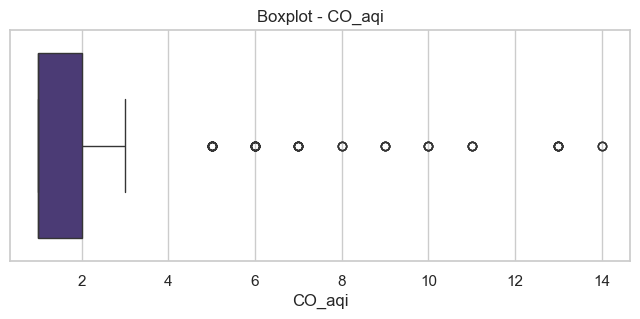

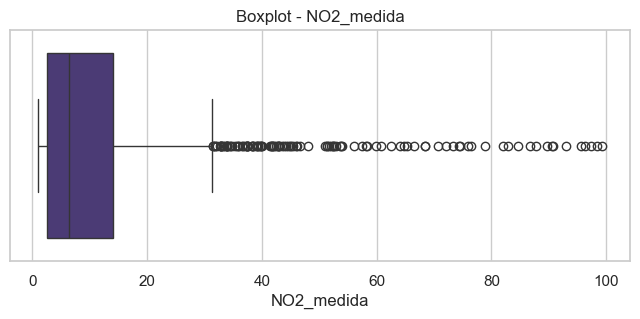

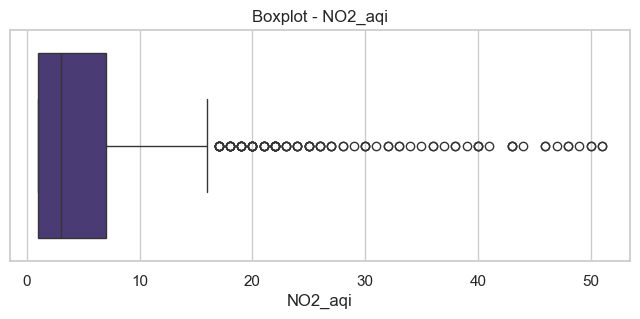

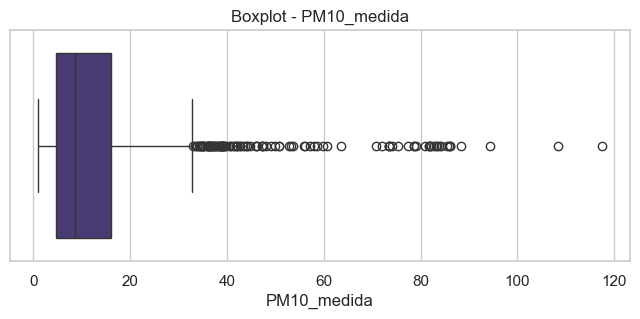

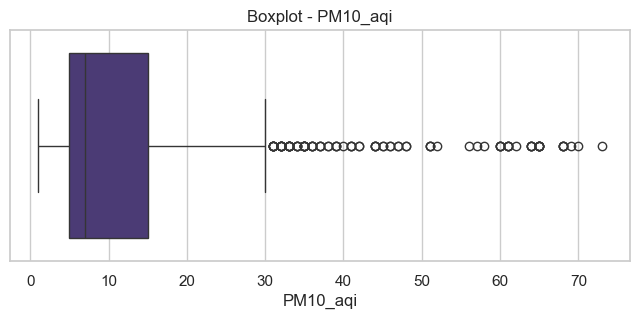

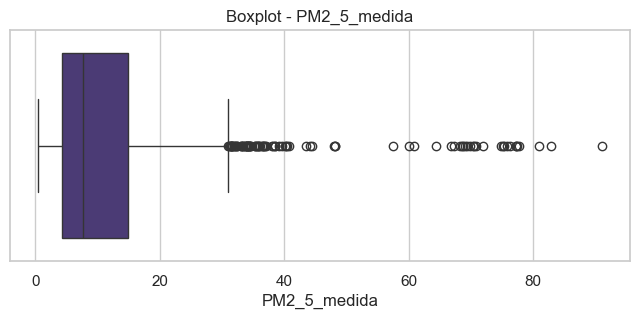

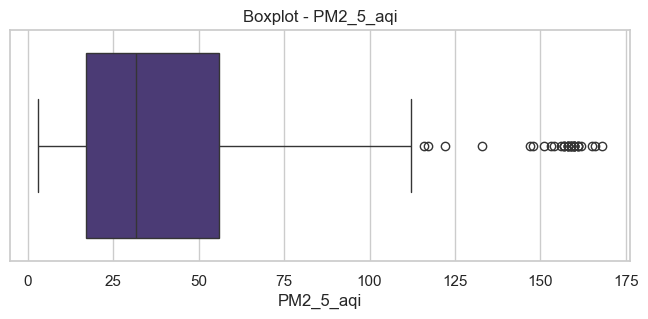

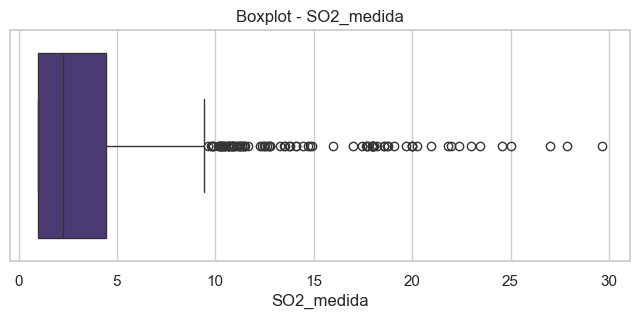

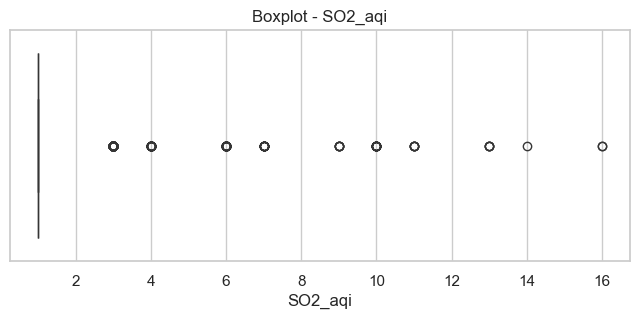

In [10]:
eda_histograms(df_train, cols_poluentes)
eda_boxplots(df_train, cols_poluentes)

- **O3_medida / O3_aqi**
    + Distribuição levemente assimétrica.
    + Grande concentração entre 20–60.
    + Cauda curta de valores mais altos.
    +  *Interpretação*: O ozônio costuma ter picos ocasionais, mas de forma geral é relativamente estável. Pode ser um indicativo moderado de poluição.

- **CO_medida / CO_aqi**
    + Extremamente assimétricos.
    + Muitos valores próximos de zero.
    + Cauda longa atingindo valores bem altos.
    + *Interpretação*: CO é claramente uma variável com muitos valores muito baixos e alguns picos isolados (talvez áreas industriais, tráfego intenso, ou falhas pontuais de medição).

- **NO2_medida / NO2_aqi**
    + Muito concentrado perto de zero.
    + Poucos valores mais altos (>60).
    + *Interpretação*: NO₂ está fortemente associado a poluição por tráfego e combustão. Mesmo com baixa ocorrência de picos, os valores altos podem discriminar bem locais poluídos.

- **PM10_medida / PM10_aqi**
    + Assimetria muito forte.
    + Grande concentração perto de zero.
    + Cauda longa.
    + *Interpretação*: PM10 é uma das métricas mais importantes para classificar poluição e aqui ela parece ter vários valores extremos. É uma variável com comportamento ideal para ser usada como feature principal no modelo.

- **PM2_5_medida / PM2_5_aqi**
    + Distribuição semelhante ao PM10, mas menos extrema.
    + Valores médios variam entre 10–50 com cauda até >100.
    + *Interpretação*: PM2.5 é extremamente correlacionado com riscos para saúde e é um excelente indicador de poluição. Precisará de transformação por causa da cauda longa.

- **SO2_medida / SO2_aqi**
    + Muito concentrado abaixo de 5.
    + Pouquíssimos valores altos.
    + *Interpretação*: SO₂ costuma ser baixo em muitos lugares e só sobe em regiões industriais ou queima de carvão. Pode ajudar a identificar locais específicos fortemente poluídos, mas não será tão útil para generalização.


### Graficos Correlações

In [11]:

def eda_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=False, cmap="viridis", linewidths=0.5)
    plt.title("Matriz de Correlação")
    plt.show()

    return corr


def eda_target_correlation(df):
    numeric_df = df.select_dtypes(include=np.number)
    corrs = numeric_df.corr()["polluted"].sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=corrs.index, y=corrs.values)
    plt.xticks(rotation=90)
    plt.title("Correlação de cada variável com 'polluted'")
    plt.show()


def eda_pairplot(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns

    sns.pairplot(df[cols], diag_kind="kde", corner=True)
    plt.show()


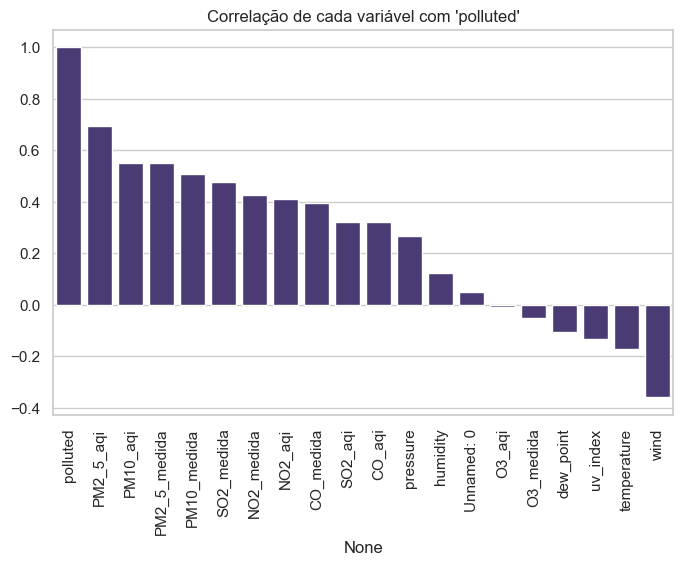

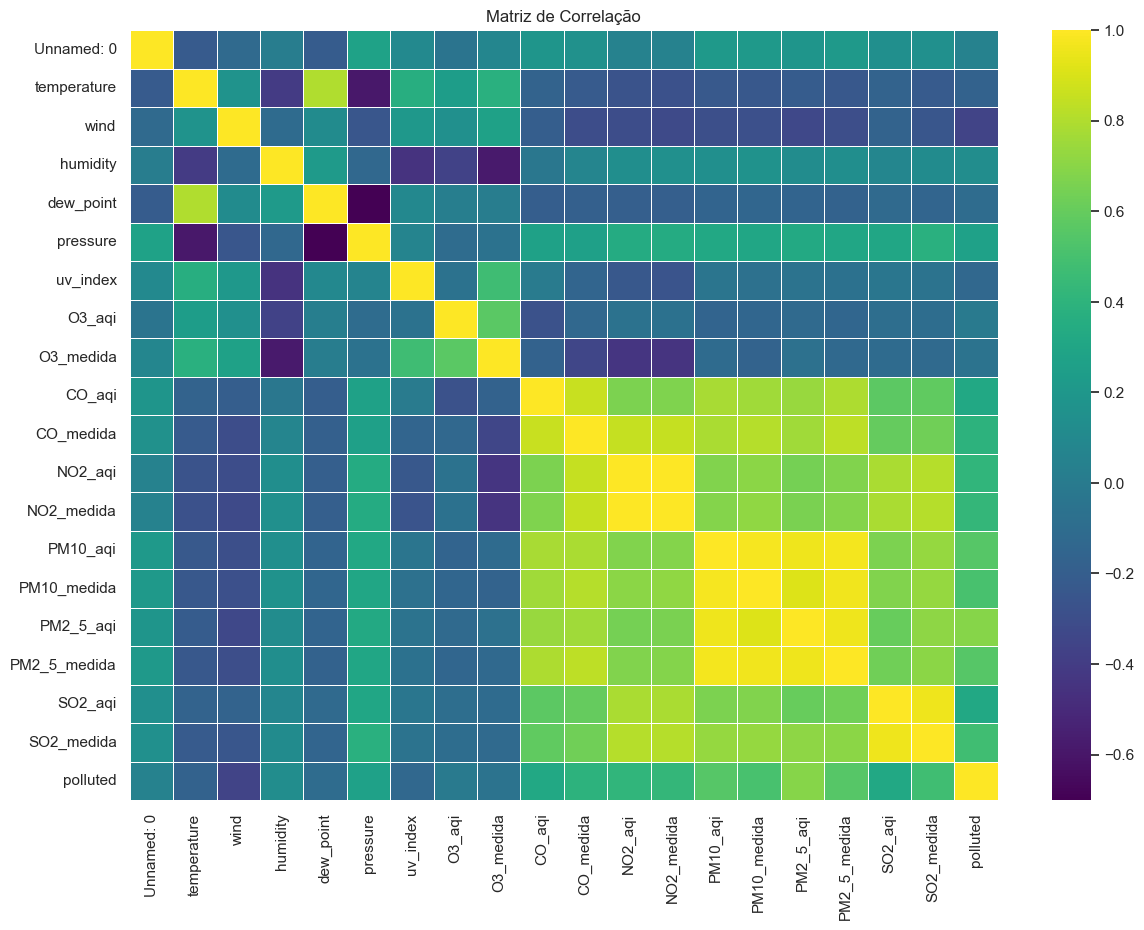

In [12]:
eda_target_correlation(df_train)
corr = eda_correlation_matrix(df_train)

- *Forte correlação entre “medida” e “aqi” de cada poluente*: Essa relação é esperada, pois o AQI é um índice derivado diretamente da concentração medida.
Isso reforça que usar ao mesmo tempo medidas e AQI no modelo introduziria multicolinearidade.

- *Poluentes apresentam forte correlação entre si*: As concentrações medidas de poluentes apresentam correlação positiva moderada a alta entre si, especialmente ->
(PM10_medida, PM2_5_medida e NO2_medida)
(CO_medida e NO2_medida)
(PM10_aqi, PM2_5_aqi e NO2_aqi)
Isso sugere que ambientes com alta concentração de um poluente geralmente têm níveis elevados de outros poluentes também.

- *Correlação dos poluentes com a variável-alvo polluted* A variável polluted apresenta maior correlação com:
    + PM10_medida
    + PM2_5_medida
    + NO2_medida
    + CO_medida

    Esses são os poluentes mais influentes na determinação de ambientes poluídos, segundo a estrutura do dataset.
    Eles tendem a subir juntos quando o ambiente encontra-se em condição considerada poluída.

    Por outro lado, variáveis climáticas como temperatura, umidade, pressão e vento possuem correlação fraca ou neutra com polluted, indicando que fatores meteorológicos têm impacto bem menor no rótulo final.

- *Variáveis climáticas possuem pouca influência*: Temperatura, vento, umidade e ponto de orvalho apresentam correlações baixas com os níveis de poluição. Isso mostra que, no dataset, as condições meteorológicas não são determinantes diretas na classificação do ambiente como poluído ou não.

## Treinamento

Para o treinamento vamos seguir a seguinte abordagem:
- Treinamento com as features AQI e Medidas separadamente para comparação.
- Treinamento de alguns modelos para escolher o mais satisfatório
- Caso necessário realziar uma tunagem de hiperparametros

### Função para realizar o treinamento de acordo com os parametros passados

In [13]:
def train_and_compare_models(
    df: pd.DataFrame,
    feature_columns: list,
    target_column: str,
    models: dict,
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Train and compare multiple machine learning models using a unified pipeline.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing features and target column.
    
    feature_columns : list
        List of column names to use as model input features.
    
    target_column : str
        Column name representing the target variable.
    
    models : dict
        A dictionary where keys are model names (str) and values are instantiated ML models.
        Example:
            models = {
                "RandomForest": RandomForestClassifier(),
                "XGBoost": XGBClassifier(),
                ...
            }
    
    test_size : float, optional (default=0.2)
        Percentage of data to be used for testing.
    
    random_state : int, optional (default=42)
        Random seed for reproducible results.

    Returns
    -------
    best_model : sklearn Pipeline
        The trained Pipeline containing the best-performing model.
    
    results : dict
        Dictionary containing evaluation metrics and pipeline object for each model:
        {
            "ModelName": {
                "Accuracy": float,
                "F1-score": float,
                "Pipeline": trained_pipeline
            },
            ...
        }
    """

    X = df[feature_columns].fillna(df[feature_columns].median())
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    results = {}
    best_model = None
    best_f1 = -1

    for model_name, model_instance in models.items():

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model_instance)
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[model_name] = {
            "Accuracy": acc,
            "F1-score": f1,
            "Pipeline": pipeline
        }

        if f1 > best_f1:
            best_f1 = f1
            best_model = pipeline

    return best_model, results

### Definição dos modelos que serão avaliados

In [14]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False)
}

### Treinamento (Medida)

- Features: todos os valores na versão "medida". Como vimos, as informações sobre clima não impactam tanto na classificação, assim decidimos seguir com as outras metricas somente deixando o modelo mais simples
- Target: coluna "polluted" que representa a label de se o local realmente está poluido.
- Utilizando o test_size e random_state padrão

In [15]:
features_medida = ["wind", "humidity","dew_point","pressure", "uv_index","O3_medida", "CO_medida", "NO2_medida", "PM10_medida", "PM2_5_medida", "SO2_medida"]

best_model_medida, results = train_and_compare_models(
    df_train,
    feature_columns=features_medida,
    target_column="polluted",
    models=models,
)

pd.DataFrame(results).T

c:\Users\FranciscoG\Documents\inatel\projeto-machine-learning\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:07:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,F1-score,Pipeline
LogisticRegression,0.949153,0.954887,"(StandardScaler(), LogisticRegression(max_iter..."
RandomForest,0.95339,0.958801,"(StandardScaler(), (DecisionTreeClassifier(max..."
GradientBoosting,0.961864,0.966038,"(StandardScaler(), ([DecisionTreeRegressor(cri..."
SVM,0.927966,0.93633,"(StandardScaler(), SVC())"
XGBoost,0.957627,0.962406,"(StandardScaler(), XGBClassifier(base_score=No..."


Os resultados foram excelentes levando em consideração a as metricas de avaliação, porém vamos analisar também o AQI para ter uma forma de comparação. O melhor modelo seria o randomForest que inclusive se dá melhor com valores não parametrizados em comparação com os outros reforçando que isso pode ter afetado os demais modelos.

### Treinamento (AQI)

- Features: todos os valores na versão "AQI". Como vimos, as informações sobre clima não impactam tanto na classificação, assim decidimos seguir com as outras metricas somente deixando o modelo mais simples
- Target: coluna "polluted" que representa a label de se o local realmente está poluido.
- Utilizando o test_size e random_state padrão

In [16]:
features_aqi = [ "wind", "humidity","dew_point","pressure", "uv_index", "O3_aqi", "CO_aqi", "NO2_aqi", "PM10_aqi", "PM2_5_aqi", "SO2_aqi"]

best_model_aqi, results = train_and_compare_models(
    df_train,
    feature_columns=features_aqi,
    target_column="polluted",
    models=models
)

pd.DataFrame(results).T

c:\Users\FranciscoG\Documents\inatel\projeto-machine-learning\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:07:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,F1-score,Pipeline
LogisticRegression,0.991525,0.992481,"(StandardScaler(), LogisticRegression(max_iter..."
RandomForest,1.0,1.0,"(StandardScaler(), (DecisionTreeClassifier(max..."
GradientBoosting,1.0,1.0,"(StandardScaler(), ([DecisionTreeRegressor(cri..."
SVM,0.970339,0.973783,"(StandardScaler(), SVC())"
XGBoost,1.0,1.0,"(StandardScaler(), XGBClassifier(base_score=No..."


Os resultados foram muito bons, sendo que randomForest e XGBoost acertaram em todos os casos, mostrando uma otima capacidade de classificação.

Podemos concluir que as informações de AQI trazem uma melhor performance para o modelo, assim seguiremos com os dados no formato AQI, além disso:

- Modelo mais forte e escalável: XGBoost
- Modelo mais simples, robusto e fácil de explicar: Random Forest

Como neste caso os modelos tem otima performance e já tem um excelente nivel de acertos, vamos seguir com o randomForest que traz mais simplicidade.

In [17]:

joblib.dump(best_model_aqi, "model_v1.pkl")

['model_v1.pkl']

In [18]:
X_test = df_test[features_aqi].fillna(df_test[features_aqi].median())
y_test = df_test["polluted"]

y_pred = best_model_aqi.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy no TEST:", acc)
print("F1-score no TEST:", f1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy no TEST: 1.0
F1-score no TEST: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00       311

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504



In [19]:
model = best_model_aqi.named_steps["model"]  # extrai o modelo da pipeline

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": features_aqi,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance_df

,feature,importance
9,PM2_5_aqi,0.528037
8,PM10_aqi,0.278569
7,NO2_aqi,0.070226
6,CO_aqi,0.035489
0,wind,0.020027
10,SO2_aqi,0.019899
2,dew_point,0.013505
3,pressure,0.011693
1,humidity,0.010131
5,O3_aqi,0.008734


Como vimos, o modelo trainado com os dados parametrizados teve um excelente desempenho e pode ser utilizado para classificar novos lugares como poluidos ou não. Para a aplicação do modelo, os lugares devem possuir sensores para monitorar os ambientes e passar pelo modelo para que verifique se o local está realmente poluido, deixando mais facil o trabalho de ONGs e organizações publicas para que possam atuar de maneira efetiva. O ideal seria aplicar estes sensores em diversos lugares para ter o monitoramento automatico das áreas necessárias, principalemente em áreas que podem afetar a natureza e ecossistema.